In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
65209,other,"Czarno-biała, rogata krowa stojąca na polu."
69250,other,Ne pas commander ils me disent que j'ai reçu a...
57136,other,Da wir im Baumarkt nicht fündig geworden sind ...
26342,other,حضور نے اس طرح کی حمایت شروع کی ہے جو کہ نیو ج...
73971,other,hab aus versehen reklamiert und neue bestellt
...,...,...
21570,other,Республиканцы не хотят оспаривать тирании зако...
18227,other,Dans la description il est écrit 10 couleurs d...
42430,other,Chefe dos direitos das Nações Unidas pressiona...
17399,other,"But i ' m proud though that that you know i , ..."


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,Республиканцы не хотят оспаривать тирании зако...
23996,other,Dans la description il est écrit 10 couleurs d...
23997,other,Chefe dos direitos das Nações Unidas pressiona...
23998,other,"But i ' m proud though that that you know i , ..."


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.util import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.20it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.54it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.50it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.14it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.35it/s]


Processing page 7 of 8...


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.18it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.40it/s]


Processing page 8 of 8...


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  5.10it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [17]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [18]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [19]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [20]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [21]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [22]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [23]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [25]:
from src.crawling import meDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [26]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), search_url, max_scrolls=10, verbose=True)

Scrolling (0 out of max 10)...
Scrolling (1 out of max 10)...
Scrolling (2 out of max 10)...
Scrolling (3 out of max 10)...
Scrolling (4 out of max 10)...
Scrolling (5 out of max 10)...
Scrolling (6 out of max 10)...
Scrolling (7 out of max 10)...
Scrolling (8 out of max 10)...
Scrolling (9 out of max 10)...
Scrolling (10 out of max 10)...


In [27]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nΑντώνης Ρέμος - Χίλια Σπίρτα - Official Mu...,/watch?v=sTyGh6edBRQ&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nAnastasia - Omorfi | Αναστασία - Όμορφη (O...,/watch?v=f8wpmLCmbas&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nGreek Ultra Hits Non Stop Mix By Nikos Hal...,/watch?v=KhCU68Eok9E&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
223,\n\nΕλληνικά Παιδικά Τραγούδια | Paidika Trago...,/watch?v=E4_rZaXZlDo&pp=ygUjzrXOu867zrfOvc65zr...
224,\n\nΧρήστος Μενιδιάτης – Από Σήμερα | Official...,/watch?v=6-UiKOxBXc8&pp=ygUjzrXOu867zrfOvc65zr...
225,\n\nπαιδιά τραγούδια | Ελληνικά Χριστουγεννιάτ...,/watch?v=CoFLfM4beq4&pp=ygUjzrXOu867zrfOvc65zr...
226,\n\nStavento feat. Ήβη Αδάμου - Για Σένα (Offi...,/watch?v=mYkJ-Hrw1LA&pp=ygUjzrXOu867zrfOvc65zr...


In [28]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
3,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
4,Greek Ultra Hits Non Stop Mix By Nikos Halkous...,https://www.youtube.com/watch?v=KhCU68Eok9E&pp...
...,...,...
223,Ελληνικά Παιδικά Τραγούδια | Paidika Tragoudia,https://www.youtube.com/watch?v=E4_rZaXZlDo&pp...
224,Χρήστος Μενιδιάτης – Από Σήμερα | Official Mus...,https://www.youtube.com/watch?v=6-UiKOxBXc8&pp...
225,παιδιά τραγούδια | Ελληνικά Χριστουγεννιάτικα ...,https://www.youtube.com/watch?v=CoFLfM4beq4&pp...
226,Stavento feat. Ήβη Αδάμου - Για Σένα (Official...,https://www.youtube.com/watch?v=mYkJ-Hrw1LA&pp...


In [29]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
3,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
5,"Πουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, Μπέλ...",https://www.youtube.com/watch?v=cOGip_clrKY&pp...
6,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
...,...,...
223,Ελληνικά Παιδικά Τραγούδια | Paidika Tragoudia,https://www.youtube.com/watch?v=E4_rZaXZlDo&pp...
224,Χρήστος Μενιδιάτης – Από Σήμερα | Official Mus...,https://www.youtube.com/watch?v=6-UiKOxBXc8&pp...
225,παιδιά τραγούδια | Ελληνικά Χριστουγεννιάτικα ...,https://www.youtube.com/watch?v=CoFLfM4beq4&pp...
226,Stavento feat. Ήβη Αδάμου - Για Σένα (Official...,https://www.youtube.com/watch?v=mYkJ-Hrw1LA&pp...


In [30]:
import bs4
import threading


def scrape_job(yt_url: str) -> tuple[str, bs4.BeautifulSoup]:
    try:
        result = scrape_youtube(ChromeDriverManager.get(), 
                                yt_url, 
                                scroll_wait_secs=2,
                                max_scrolls=15,
                                verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [31]:
import concurrent.futures


jobs = 15
# get at most max_videos, if more videos were crawled during the search
max_videos = 150
urls = gr_res_df.link[:max_videos] if len(gr_res_df) > max_videos else gr_res_df

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))

ChromeDriverManager.quit()

Scrapping comments...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [04:51<00:00,  1.94s/it]


In [32]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

for url, result in results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

In [63]:
comments_df = pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Υπέροχα τραγούδια μπράβο,2022-11-25 11:50:59.010531
1,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ωραία τραγούδια!! Καλή επιλογή!,2022-11-25 11:50:59.015417
2,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ότι αξίζει είναι πάντα κοντά σου,2021-11-25 11:50:59.018419
3,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"ΚΑΛΗΜΕΡΑ,ΥΠΕΡΟΧΑ ΤΡΑΓΟΥΔΙΑ,ΜΠΡΑΒΟ..!!!!!",2021-11-25 11:50:59.021437
4,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ότι είναι δικό σου γυρίζει,2021-11-25 11:50:59.024474
...,...,...,...
1405,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,"Εκπληκτικές επιλογές, μαγευτικεεες 1000 μπράβο",2022-11-25 11:51:07.001769
1406,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Όμορφες επιλογές αγαπημένα όλα,2022-11-25 11:51:07.004803
1407,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Υπέροχο,2022-11-25 11:51:07.007796
1408,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Όσοι μιλούν λίγο ακούγονται δύο φορές περισσότ...,2023-04-25 11:51:07.012855


In [64]:
comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)

preds = greeklish_model.predict(comments_df.text)
mask = ((preds != "el") & (preds != "greeklish"))
comments_df[mask]

,link,text,date
5,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,,2021-11-25
7,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Greece established in 1999 by British\nLong li...,2022-11-25
9,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,🇬🇷🇬🇷🇬🇷🇬🇷🇬🇷🇬🇷️,2021-11-25
11,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,,2021-11-25
13,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,My dream is to date and marry a Greek girl woman,2022-11-25
...,...,...,...
1368,https://www.youtube.com/watch?v=eGGWmivIHYQ&pp...,🇬🇷️,2023-02-25
1377,https://www.youtube.com/watch?v=Vgdc_7nDPqI&pp...,🇬🇷️,2023-02-25
1386,https://www.youtube.com/watch?v=c2qFbcDRCV8&pp...,🇬🇷️,2023-02-25
1395,https://www.youtube.com/watch?v=SFTvzvefR04&pp...,🇬🇷️,2023-02-25


In [65]:
crawl_df = pd.merge(gr_res_df, comments_df[~mask], how="inner", on="link")
crawl_df

,title,link,text,date
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Υπέροχα τραγούδια μπράβο,2022-11-25
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ωραία τραγούδια!! Καλή επιλογή!,2022-11-25
2,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ότι αξίζει είναι πάντα κοντά σου,2021-11-25
3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"ΚΑΛΗΜΕΡΑ,ΥΠΕΡΟΧΑ ΤΡΑΓΟΥΔΙΑ,ΜΠΡΑΒΟ..!!!!!",2021-11-25
4,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ότι είναι δικό σου γυρίζει,2021-11-25
...,...,...,...,...
862,Έχεις το χρώμα του Ουρανού | Ελληνικές Μπαλάντ...,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,"Εκπληκτικές επιλογές, μαγευτικεεες 1000 μπράβο",2022-11-25
863,Έχεις το χρώμα του Ουρανού | Ελληνικές Μπαλάντ...,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Όμορφες επιλογές αγαπημένα όλα,2022-11-25
864,Έχεις το χρώμα του Ουρανού | Ελληνικές Μπαλάντ...,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Υπέροχο,2022-11-25
865,Έχεις το χρώμα του Ουρανού | Ελληνικές Μπαλάντ...,https://www.youtube.com/watch?v=20EaBkhFqI8&pp...,Όσοι μιλούν λίγο ακούγονται δύο φορές περισσότ...,2023-04-25


In [66]:
sum(crawl_df.date == None)

0

In [67]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


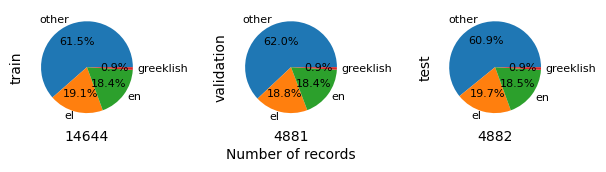

In [172]:
from src.ml import train_test_val_split


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [173]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14644, 66832), (14644,), (4882, 66832), (4882,))

In [174]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [175]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.1891633770533554
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       962
          en       0.00      0.00      0.00       903
   greeklish       0.00      0.00      0.00        46
       other       0.61      1.00      0.76      2971

    accuracy                           0.61      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.37      0.61      0.46      4882



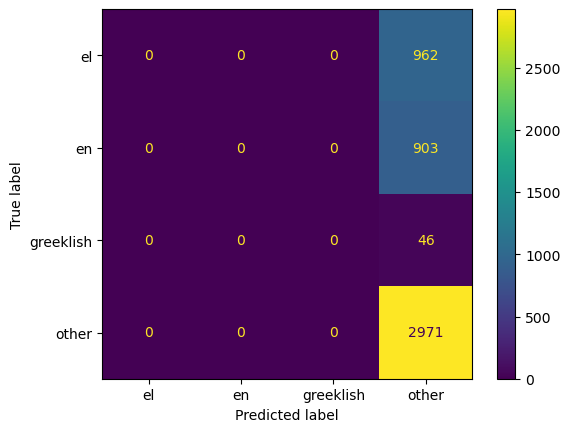

In [176]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [177]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5174, std: 0.5005


Macro F1: 0.5044666696783363
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       962
          en       0.32      1.00      0.48       903
   greeklish       0.00      0.00      0.00        46
       other       1.00      0.37      0.54      2971

    accuracy                           0.60      4882
   macro avg       0.58      0.59      0.50      4882
weighted avg       0.86      0.60      0.61      4882



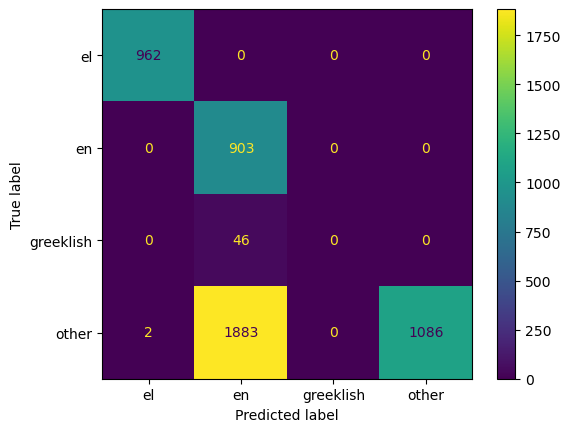

In [178]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [ ]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

In [ ]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

In [83]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 23 minutes and 59.4 seconds
